## Importing Libraries

In [3]:
%%capture

import numpy as np 
import pandas as pd 
import os
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from sklearn.model_selection import KFold, GroupKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.special import kl_div

from sklearn.neighbors import KNeighborsClassifier
from multiprocessing import Pool
from sklearn.impute import SimpleImputer


from glob import glob


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
!pip install tensorflow tensorflow-gpu 

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      Traceback (most recent call last):
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_vendor/packaging/requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_vendor/packaging/_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_vendor/packaging/_parser.py", line 82, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_vendor/packaging/_parser.py", line 126, in _parse_requirement_details
      

## Loading Training Data

In [5]:
train0= pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
print(train0.shape)
train0.info()

(106800, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106800 entries, 0 to 106799
Data columns (total 15 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   eeg_id                            106800 non-null  int64  
 1   eeg_sub_id                        106800 non-null  int64  
 2   eeg_label_offset_seconds          106800 non-null  float64
 3   spectrogram_id                    106800 non-null  int64  
 4   spectrogram_sub_id                106800 non-null  int64  
 5   spectrogram_label_offset_seconds  106800 non-null  float64
 6   label_id                          106800 non-null  int64  
 7   patient_id                        106800 non-null  int64  
 8   expert_consensus                  106800 non-null  object 
 9   seizure_vote                      106800 non-null  int64  
 10  lpd_vote                          106800 non-null  int64  
 11  gpd_vote                          10680

In [6]:
train0.describe()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
count,1.068000e+05,106800.000000,106800.000000,1.068000e+05,106800.000000,106800.000000,1.068000e+05,106800.000000,106800.000000,106800.000000,106800.000000,106800.000000,106800.000000,106800.000000
mean,2.104387e+09,26.286189,118.817228,1.067262e+09,43.733596,520.431404,2.141415e+09,32304.428493,0.878024,1.138783,1.264925,0.948296,1.059185,1.966283
std,1.233371e+09,69.757658,314.557803,6.291475e+08,104.292116,1449.759868,1.241670e+09,18538.196252,1.538873,2.818845,3.131889,2.136799,2.228492,3.621180
min,5.686570e+05,0.000000,0.000000,3.537330e+05,0.000000,0.000000,3.380000e+02,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.026896e+09,1.000000,6.000000,5.238626e+08,2.000000,12.000000,1.067419e+09,16707.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.071326e+09,5.000000,26.000000,1.057904e+09,8.000000,62.000000,2.138332e+09,32068.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.172787e+09,16.000000,82.000000,1.623195e+09,29.000000,394.000000,3.217816e+09,48036.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000
max,4.294958e+09,742.000000,3372.000000,2.147388e+09,1021.000000,17632.000000,4.294934e+09,65494.000000,19.000000,18.000000,16.000000,15.000000,15.000000,25.000000


In [7]:
train0.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [8]:
train0.shape

(106800, 15)

In [9]:

features = train0.drop(['eeg_id', 'spectrogram_id', 'eeg_sub_id', 'label_id', 'expert_consensus'], axis=1)
target = list(train0.columns[-6:])
print(target)


['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


In [10]:
TARGETS = target
TARGETS

['seizure_vote',
 'lpd_vote',
 'gpd_vote',
 'lrda_vote',
 'grda_vote',
 'other_vote']

In [ ]:
train0.head(50)

In [ ]:
pd.unique(train0['expert_consensus'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


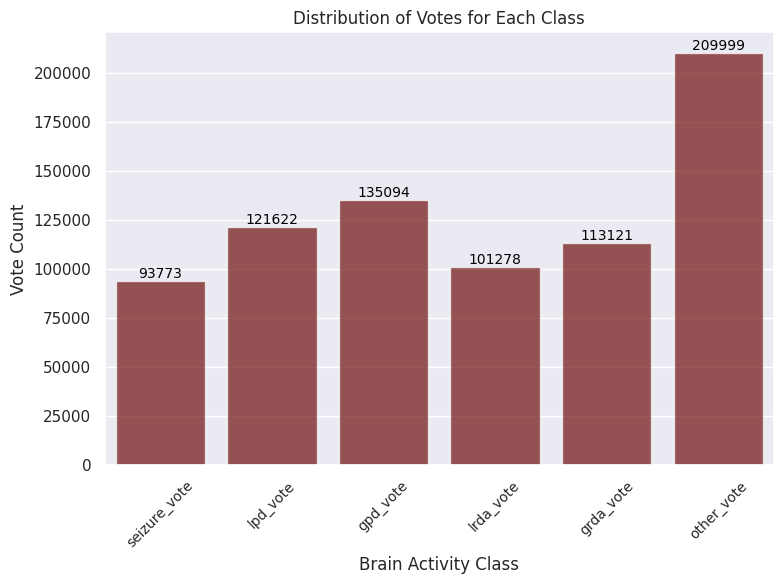

In [11]:
sns.set(style='darkgrid')

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=target, y=train0[target].sum(), color='maroon', alpha = 0.7)

# data labels above the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Distribution of Votes for Each Class')
plt.xlabel('Brain Activity Class')
plt.ylabel('Vote Count')
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()


In [12]:
# Reading a single Parquet file

# DataFrame with paths to all Parquet files
df = pd.DataFrame({'path': glob('/kaggle/input/hms-harmful-brain-activity-classification/**/*.parquet')})

df['test_type'] = df['path'].str.split('/').str[-2].str.split('_').str[-1]
df['id'] = df['path'].str.split('/').str[-1].str.split('.').str[0]

df_eeg = pd.read_parquet('/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/1000913311.parquet')
df_eeg.head()

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-105.849998,-89.230003,-79.459999,-49.230000,-99.730003,-87.769997,-53.330002,-50.740002,-32.250000,-42.099998,-43.270000,-88.730003,-74.410004,-92.459999,-58.930000,-75.739998,-59.470001,8.210000,66.489998,1404.930054
1,-85.470001,-75.070000,-60.259998,-38.919998,-73.080002,-87.510002,-39.680000,-35.630001,-76.839996,-62.740002,-43.040001,-68.629997,-61.689999,-69.320000,-35.790001,-58.900002,-41.660000,196.190002,230.669998,3402.669922
2,8.840000,34.849998,56.430000,67.970001,48.099998,25.350000,80.250000,48.060001,6.720000,37.880001,61.000000,16.580000,55.060001,45.020000,70.529999,47.820000,72.029999,-67.180000,-171.309998,-3565.800049
3,-56.320000,-37.279999,-28.100000,-2.820000,-43.430000,-35.049999,3.910000,-12.660000,8.650000,3.830000,4.180000,-51.900002,-21.889999,-41.330002,-11.580000,-27.040001,-11.730000,-91.000000,-81.190002,-1280.930054
4,-110.139999,-104.519997,-96.879997,-70.250000,-111.660004,-114.430000,-71.830002,-61.919998,-76.150002,-79.779999,-67.480003,-99.029999,-93.610001,-104.410004,-70.070000,-89.250000,-77.260002,155.729996,264.850006,4325.370117


In [13]:
df.head()

,path,test_type,id
0,/kaggle/input/hms-harmful-brain-activity-class...,eegs,2208063991
1,/kaggle/input/hms-harmful-brain-activity-class...,eegs,1712674008
2,/kaggle/input/hms-harmful-brain-activity-class...,eegs,3959808174
3,/kaggle/input/hms-harmful-brain-activity-class...,eegs,2958965493
4,/kaggle/input/hms-harmful-brain-activity-class...,eegs,3973731145


In [ ]:
df_eeg.shape   # -> [#time points, #channels]

In [ ]:
# %%time

# # spectrogram files
# files = os.listdir('/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/')
# print(len(files), 'files')

# spectrograms = {}
# for i, f in enumerate(files):
#     print("Processing file", i+1, end = '\r')
#     spectrograms[int(f.split('.')[0])] = pd.read_parquet('/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/' + f).iloc[:, 1:].values

# print("Processing complete. Total spectrograms processed:", len(spectrograms))

In [14]:
%%time

# spectrogram files

def read_spectrogram(file):
    file_path = '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/' + file
    spectrogram = pd.read_parquet(file_path).iloc[:, 1:].values
    return int(file.split('.')[0]), spectrogram

files = os.listdir('/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/')
print(len(files), 'files')

# Use multiprocessing to read spectrogram files concurrently
with Pool() as pool:
    spectrograms = dict(pool.map(read_spectrogram, files))

print("Processing complete. Total spectrograms processed:", len(spectrograms))


11138 files
Processing complete. Total spectrograms processed: 11138
CPU times: user 18.2 s, sys: 19.9 s, total: 38.1 s
Wall time: 3min 16s


In [15]:
# One parquet file in train_spectrogram

df_eeg = pd.read_parquet('/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/1000086677.parquet')

df_eeg.head()

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,1,28.680000,53.990002,67.629997,59.880001,50.880001,74.309998,78.480003,63.080002,59.869999,...,0.13,0.14,0.08,0.11,0.04,0.03,0.05,0.05,0.04,0.05
1,3,29.639999,38.959999,44.009998,66.800003,48.509998,42.180000,47.340000,48.599998,40.880001,...,0.15,0.13,0.08,0.08,0.07,0.06,0.07,0.06,0.06,0.06
2,5,8.890000,9.020000,16.360001,23.559999,27.340000,30.040001,27.559999,23.290001,15.120000,...,0.12,0.11,0.08,0.08,0.09,0.10,0.12,0.14,0.13,0.14
3,7,1.770000,1.930000,1.810000,1.600000,1.430000,1.280000,1.190000,1.110000,1.010000,...,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.04,0.04,0.04
4,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.head()

In [ ]:
target

## Creating Non-Overlapping EEG ID Train Data

## Creating Unique EEG Segments

The EEG data is grouped by `eeg_id`, and the first `spectrogram_id` and the earliest `spectrogram_label_offset_seconds` are selected for each `eeg_id`. This establishes the starting point of each EEG segment.

### train (updated)

| eeg_id | spectrogram_id | start_time |
|--------|----------------|------------|
| 1      | 101            | 10         |
| 2      | 103            | 5          |

## Determining the Latest Point in Each EEG Segment

Here, we group the data by `eeg_id` again and find the latest `spectrogram_label_offset_seconds` for each segment. This maximum value is appended to the `train` DataFrame, representing the end point of each EEG segment.

### train (updated)

| eeg_id | spectrogram_id | start_time | end_time |
|--------|----------------|------------|----------|
| 1      | 101            | 10         | 15       |
| 2      | 103            | 5          | 20       |

## Incorporating Patient Information

The `patient_id` corresponding to each `eeg_id` is added to the `train` DataFrame, establishing a link between each EEG segment and a specific patient.

### train (updated)

| eeg_id | spectrogram_id | start_time | end_time | patient_id |
|--------|----------------|------------|----------|------------|
| 1      | 101            | 10         | 15       | 1          |
| 2      | 103            | 5          | 20       | 2          |

## Summing Target Variable Counts

We then sum up the counts of target variables (e.g., seizure votes, LPD votes) for each `eeg_id`.

### train (updated)

| eeg_id | spectrogram_id | start_time | end_time | patient_id | seizure_vote | lpd_vote | gpd_vote | lrda_vote | grda_vote | other_vote |
|--------|----------------|------------|----------|------------|--------------|----------|----------|-----------|-----------|------------|
| 1      | 101            | 10         | 15       | 1          | 6            | 0        | 0        | 0         | 0         | 0          |
| 2      | 103            | 5          | 20       | 2          | 0            | 0        | 2        | 0         | 0         | 0          |

## Normalizing Target Variable Counts

The counts are normalized to ensure they sum up to 1, converting them into probabilities.

### train (updated)

| eeg_id | spectrogram_id | start_time | end_time | patient_id | seizure_vote | lpd_vote | gpd_vote | lrda_vote | grda_vote | other_vote |
|--------|----------------|------------|----------|------------|--------------|----------|----------|-----------|-----------|------------|
| 1      | 101            | 10         | 15       | 1          | 1            | 0        | 0        | 0         | 0         | 0          |
| 2      | 103            | 5          | 20       | 2          | 0            | 0        | 1        | 0         | 0         | 0          |

## Including Expert Consensus

For each `eeg_id`, the `expert_consensus` on the EEG segment's classification is included in the dataframe.

### train (updated)

| eeg_id | spectrogram_id | start_time | end_time | patient_id | seizure_vote | lpd_vote | gpd_vote | lrda_vote | grda_vote | other_vote | target |
|--------|----------------|------------|----------|------------|--------------|----------|----------|-----------|-----------|------------|--------|
| 1      | 101            | 10         | 15       | 1          | 1            | 0        | 0        | 0         | 0         | 0          | Seizure|
| 2      | 103            | 5          | 20       | 2          | 0            | 0        | 1        | 0         | 0         | 0          | GPD    |


In [16]:
# Creating Unique EEG Segments:
# The EEG data is grouped by eeg_id, and the first spectrogram_id and the earliest spectrogram_label_offset_seconds is selected for each eeg_id. This establishes the starting point of each EEG segment.


train = train0.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','start_time']


# Determining the Latest Point in Each EEG Segment:
# Here, we group the data by eeg_id again and find the latest spectrogram_label_offset_seconds for each segment. This maximum value is appended to the train DataFrame, representing the end point of each EEG segment.

tmp = train0.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['end_time'] = tmp

# The patient_id corresponding to each eeg_id is added to the train DataFrame, establishing a link between each EEG segment and a specific patient.
tmp = train0.groupby('eeg_id')[['patient_id']].agg('first') 
train['patient_id'] = tmp

# We then sum up the counts of target variables (e.g., seizure votes, LPD votes) for each eeg_id.
tmp = train0.groupby('eeg_id')[target].agg('sum')
for t in target:
    train[t] = tmp[t].values
    

# The counts are normalized to ensure they sum up to 1, converting them into probabilities.
y_data = train[target].values
y_data = y_data / y_data.sum(axis=1, keepdims=True)
train[target] = y_data


# For each eeg_id, the expert_consensus on the EEG segment's classification is included in the dataframe.
tmp = train0.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

# The eeg_id is converted into a regular column
train = train.reset_index() 
print('Shape of EEG segments without overlap in training data:', train.shape )
train.head()

Shape of EEG segments without overlap in training data: (17089, 12)


,eeg_id,spec_id,start_time,end_time,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


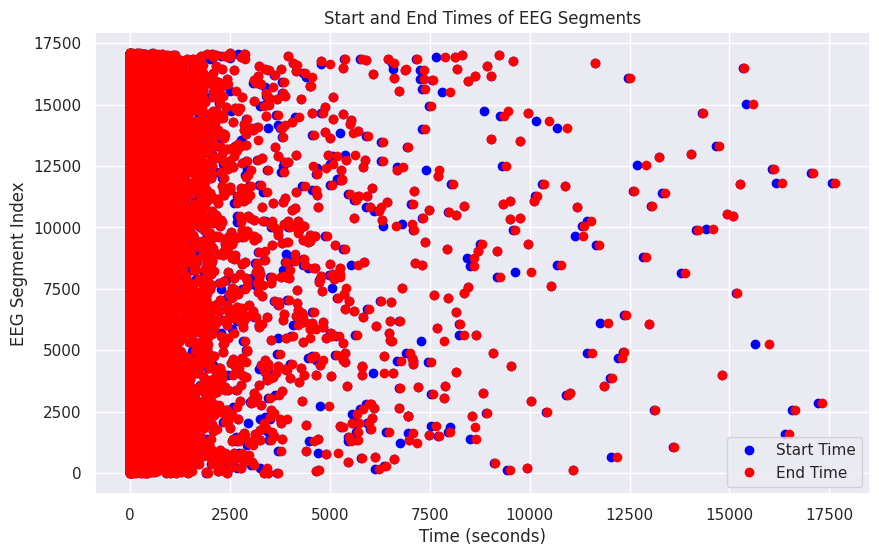

In [17]:

# start and end times of EEG segments
plt.figure(figsize=(10, 6))
plt.plot(train['start_time'], train.index, label='Start Time', marker='o', linestyle='', color='blue')
plt.plot(train['end_time'], train.index, label='End Time', marker='o', linestyle='', color='red')
plt.xlabel('Time (seconds)')
plt.ylabel('EEG Segment Index')
plt.title('Start and End Times of EEG Segments')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# FEATS = [['Fp1','F7','T3','T5','O1'],
#          ['Fp1','F3','C3','P3','O1'],
#          ['Fp2','F8','T4','T6','O2'],
#          ['Fp2','F4','C4','P4','O2']]

In [18]:
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/'
SPEC_COLS = pd.read_parquet(f'{PATH}1000086677.parquet').columns[1:]
print(SPEC_COLS.shape)
SPEC_COLS

(400,)


Index(['LL_0.59', 'LL_0.78', 'LL_0.98', 'LL_1.17', 'LL_1.37', 'LL_1.56',
       'LL_1.76', 'LL_1.95', 'LL_2.15', 'LL_2.34',
       ...
       'RP_18.16', 'RP_18.36', 'RP_18.55', 'RP_18.75', 'RP_18.95', 'RP_19.14',
       'RP_19.34', 'RP_19.53', 'RP_19.73', 'RP_19.92'],
      dtype='object', length=400)

In [19]:
SPEC_COLS

Index(['LL_0.59', 'LL_0.78', 'LL_0.98', 'LL_1.17', 'LL_1.37', 'LL_1.56',
       'LL_1.76', 'LL_1.95', 'LL_2.15', 'LL_2.34',
       ...
       'RP_18.16', 'RP_18.36', 'RP_18.55', 'RP_18.75', 'RP_18.95', 'RP_19.14',
       'RP_19.34', 'RP_19.53', 'RP_19.73', 'RP_19.92'],
      dtype='object', length=400)

In [20]:
import warnings
warnings.filterwarnings('ignore')


spectrogram_columns = pd.read_parquet(f'{PATH}1000086677.parquet').columns[1:]
features = [f'{c}_mean_10m' for c in spectrogram_columns]
features += [f'{c}_min_10m' for c in spectrogram_columns]
features += [f'{c}_mean_20s' for c in spectrogram_columns]
features += [f'{c}_min_20s' for c in spectrogram_columns]
features += [f'{c}_mean_10s' for c in spectrogram_columns]
features += [f'{c}_min_10s' for c in spectrogram_columns]
print(f'We need to create {len(features)} features for {len(train)} rows... ')


# Initializing data matrix to store new features
data = np.zeros((len(train), len(features)))



We need to create 2400 features for 17089 rows... 


In [21]:
%%time
# Iterating through each row in train


for i, row in train.iterrows():
    if i % 100 == 0:
        print(i, ' ', end='')


    window_range = int((row['start_time'] + row['end_time']) // 4)

    # Calculating features for 10-minute window
    window_10_min = spectrograms[row.spec_id][window_range:window_range + 300, :]
    data[i, :400] = np.nanmean(window_10_min, axis=0)
    data[i, 400:800] = np.nanmin(window_10_min, axis=0)

    # Calculating features for 20-second window
    window_20_sec = spectrograms[row.spec_id][window_range + 145:window_range + 155, :]
    data[i, 800:1200] = np.nanmean(window_20_sec, axis=0)
    data[i, 1200:1600] = np.nanmin(window_20_sec, axis=0)
    
    # Calculating features for 10-second window
    window_10_sec = spectrograms[row.spec_id][window_range + 147:window_range + 153, :]
    data[i, 1600:2000] = np.nanmean(window_10_sec, axis=0)
    data[i, 2000:2400] = np.nanmin(window_10_sec, axis=0)
    

# Adding new features to train DataFrame
train[features] = data

print()
print('New train shape:',train.shape)


0  100  200  300  400  500  600  700  800  900  1000  1100  1200  1300  1400  1500  1600  1700  1800  1900  2000  2100  2200  2300  2400  2500  2600  2700  2800  2900  3000  3100  3200  3300  3400  3500  3600  3700  3800  3900  4000  4100  4200  4300  4400  4500  4600  4700  4800  4900  5000  5100  5200  5300  5400  5500  5600  5700  5800  5900  6000  6100  6200  6300  6400  6500  6600  6700  6800  6900  7000  7100  7200  7300  7400  7500  7600  7700  7800  7900  8000  8100  8200  8300  8400  8500  8600  8700  8800  8900  9000  9100  9200  9300  9400  9500  9600  9700  9800  9900  10000  10100  10200  10300  10400  10500  10600  10700  10800  10900  11000  11100  11200  11300  11400  11500  11600  11700  11800  11900  12000  12100  12200  12300  12400  12500  12600  12700  12800  12900  13000  13100  13200  13300  13400  13500  13600  13700  13800  13900  14000  14100  14200  14300  14400  14500  14600  14700  14800  14900  15000  15100  15200  15300  15400  15500  15600  15700  15800 

In [ ]:
train.head()

In [ ]:
train.shape

In [22]:
import tensorflow as tf

In [23]:
x = train[train.columns[12:]].values
y = train[train.columns[5:11]].values

In [24]:
unique, frequency = np.unique(x, 
                              return_counts = True)

In [36]:
MAX_FEATURES = 2400

In [26]:
dataset = tf.data.Dataset.from_tensor_slices((x, y))

In [27]:
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [28]:
batch_x, batch_y = dataset.as_numpy_iterator().next()

In [31]:
train1 = dataset.take(int(len(dataset)*.8))
val = dataset.skip(int(len(dataset)*.8)).take(int(len(dataset)*.2))

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [47]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32, activation = 'tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [48]:
model.compile(loss='KLDivergence', optimizer='Adam')

In [49]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          76832     
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                      

In [50]:
history = model.fit(train1, epochs=10, validation_data=val)

Epoch 1/10
855/855 [==============================] - 245s 280ms/step - loss: 1.1385 - val_loss: 1.0582
Epoch 2/10
855/855 [==============================] - 197s 231ms/step - loss: 1.0429 - val_loss: 1.0569
Epoch 3/10
855/855 [==============================] - 175s 204ms/step - loss: 1.0089 - val_loss: 0.9591
Epoch 4/10
855/855 [==============================] - 156s 182ms/step - loss: 0.9736 - val_loss: 0.9374
Epoch 5/10
855/855 [==============================] - 146s 171ms/step - loss: 0.9363 - val_loss: 0.8832
Epoch 6/10
855/855 [==============================] - 135s 158ms/step - loss: 0.9268 - val_loss: 0.9186
Epoch 7/10
855/855 [==============================] - 131s 153ms/step - loss: 0.8871 - val_loss: 0.8180
Epoch 8/10
855/855 [==============================] - 132s 155ms/step - loss: 0.8582 - val_loss: 0.8100
Epoch 9/10
855/855 [==============================] - 125s 146ms/step - loss: 0.8343 - val_loss: 0.8046
Epoch 10/10
855/855 [==============================] - 121s 142m

In [54]:
model.save("brain.h5")

In [56]:
from tensorflow.keras.models import load_model
improved_model = load_model("brain.h5")

In [57]:
history2 = improved_model.fit(train1, epochs=50, validation_data=val)

Epoch 1/50
855/855 [==============================] - 221s 254ms/step - loss: 0.7760 - val_loss: 0.7308
Epoch 2/50
855/855 [==============================] - 179s 210ms/step - loss: 0.7561 - val_loss: 0.7311
Epoch 3/50
855/855 [==============================] - 158s 184ms/step - loss: 0.7384 - val_loss: 0.7147
Epoch 4/50
855/855 [==============================] - 152s 178ms/step - loss: 0.7218 - val_loss: 0.7047
Epoch 5/50
855/855 [==============================] - 137s 161ms/step - loss: 0.7089 - val_loss: 0.6958
Epoch 6/50
855/855 [==============================] - 130s 152ms/step - loss: 0.6948 - val_loss: 0.6723
Epoch 7/50
855/855 [==============================] - 129s 151ms/step - loss: 0.6783 - val_loss: 0.6437
Epoch 8/50
855/855 [==============================] - 128s 150ms/step - loss: 0.6585 - val_loss: 0.6324
Epoch 9/50
855/855 [==============================] - 121s 141ms/step - loss: 0.6811 - val_loss: 0.6330
Epoch 10/50
855/855 [==============================] - 121s 141m

In [59]:
improved_model.save("brain2.h5")

In [51]:
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
print('Test shape',test.shape)
test.head()

Test shape (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [52]:
# FEATURE ENGINEER TEST
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'
data = np.zeros((len(test),len(features)))
    
for k in range(len(test)):
    row = test.iloc[k]
    s = int( row.spectrogram_id )
    spec = pd.read_parquet(f'{PATH2}{s}.parquet')
    
    # 10 MINUTE WINDOW FEATURES
    x = np.nanmean( spec.iloc[:,1:].values, axis=0)
    data[k,:400] = x
    x = np.nanmin( spec.iloc[:,1:].values, axis=0)
    data[k,400:800] = x

    # 20 SECOND WINDOW FEATURES
    x = np.nanmean( spec.iloc[145:155,1:].values, axis=0)
    data[k,800:1200] = x
    x = np.nanmin( spec.iloc[145:155,1:].values, axis=0)
    data[k,1200:1600] = x

test[features] = data
print('New test shape',test.shape)

New test shape (1, 2403)


In [60]:
improved_model.predict(test[features])

1/1 [==============================] - 1s 907ms/step


array([[0.01985968, 0.00551387, 0.01804366, 0.01503568, 0.03523809,
        0.90630907]], dtype=float32)

In [61]:
preds = []

for i in range(5):
    print(i, ', ', end='')
    
    # Make predictions
    pred = improved_model.predict(test[features])
    preds.append(pred)

# Average the predictions from each fold
pred = np.mean(preds, axis=0)
print()
print('Test preds shape', pred.shape)

1/1 [==============================] - 0s 69ms/step

Test preds shape (1, 6)


In [62]:
sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
sub[TARGETS] = pred
sub.to_csv('submission.csv',index=False)
print('Submission shape',sub.shape)
sub.head()

Submission shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.01986,0.005514,0.018044,0.015036,0.035238,0.906309


In [63]:
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
sub.iloc[:,-6:].sum(axis=1)

0    1.0
dtype: float32